# Calculating the losses due to butt-to-butt fiber coupling with an air filled gap
-------------
Based on [my calculations](LPmodes.ipynb), the intensity of the counterpropagating field doesn't have to be as much as the forward propagating one for a standing wave to be established.

Used extensively for the formulas was this __[article]( https://cdn.intechopen.com/pdfs/27371/InTech-Optical_performance_analysis_of_single_mode_fiber_connections.pdf)__
They cite 4 sources of light loss when butt coupling **perfectly cleaved** fibers. These are:
<div>
<img src="fiberlosses.png" width="500"/>
</div


The only one I anticipate as being negligible is the mode field mismatch, since I am using the same fiber. The tilt misalignment will also most lilely be quite small due to the machining of the groove of the fiber holder. I'll first calculate loss as a function of air gap and lateral displacement.<br>

As a function of air gap, we have transmission coefficient $T$ given by
\begin{equation}
T = \frac{1}{Z^2+1}
\end{equation}
where 
\begin{equation}
Z = \frac{\lambda S}{2 \pi n \omega^2}
\end{equation}
where $S$ is the gap size, $n$ is the refractive index of air and $\omega$ is the MFD of the two fibers

In [4]:
import numpy as np

def Z(lam,S,n,omega):
    return (lam*S)/(2*np.pi*n*(omega**2))

def T_ag(Z):
    return 1/(Z**2 + 1)

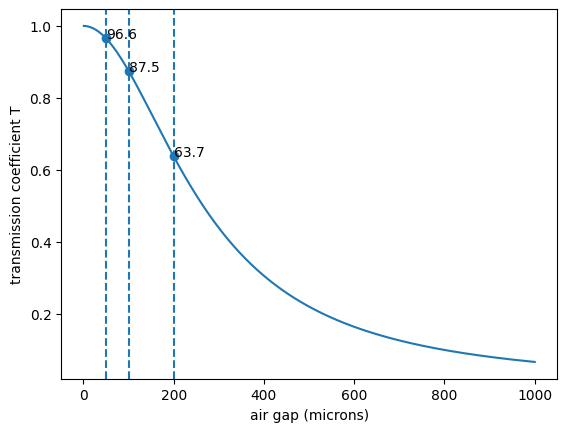

In [11]:
import matplotlib.pyplot as plt

# lab values
wavelength = 1064e-9 #m
airgap = np.linspace(1e-6,1000e-6,300) #m
RI = 1
MFD = 6.7e-6 #m

Z_airgap = Z(wavelength,airgap,RI,MFD)
T_airgap = T_ag(Z_airgap)

fig,ax = plt.subplots()
ax.plot(airgap*10**6,T_airgap)
ax.set_xlabel('air gap (microns)')
ax.set_ylabel('transmission coefficient T')
poi = np.array([50e-6,100e-6,200e-6]) # add points of interest and labels
for i in range(len(poi)):
    plt.axvline(poi[i]*10**6, linestyle='--')
Z_poi = Z(wavelength,poi,RI,MFD)
T_poi = T_ag(Z_poi)
T_labels = np.around(T_poi,3)*100
ax.scatter(poi*10**6,T_poi)
for i, txt in enumerate(T_labels):
    ax.annotate(txt, (poi[i]*10**6, T_poi[i]))
plt.show()



as a function of lateral offset $d$, we have
\begin{equation}
T = exp \left( -\frac{d^2}{\omega^2} \right)
\end{equation}

In [6]:
def T_lo(d,omega):
    return np.exp(-(d**2)/(omega**2))

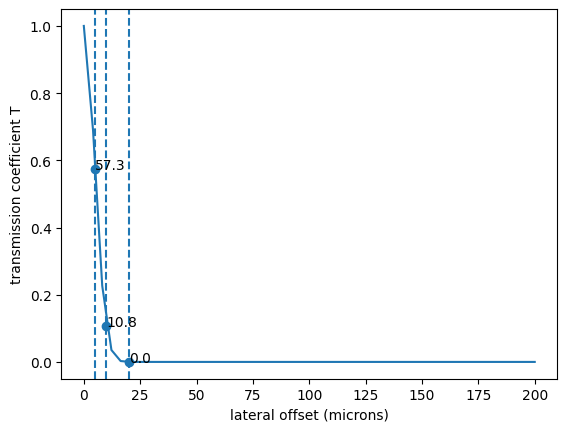

In [7]:
offset = np.linspace(0,200e-6) #m
T_offset = T_lo(offset,MFD)

fig,ax = plt.subplots()
ax.plot(offset*10**6,T_offset)
ax.set_xlabel('lateral offset (microns)')
ax.set_ylabel('transmission coefficient T')
poi = np.array([5e-6,10e-6,20e-6])
for i in range(len(poi)):
    plt.axvline(poi[i]*10**6, linestyle='--')
T_poi = T_lo(poi,MFD)
T_labels = np.around(T_poi,3)*100
ax.scatter(poi*10**6,T_poi)
for i, txt in enumerate(T_labels):
    ax.annotate(txt, (poi[i]*10**6, T_poi[i]))
plt.show()

as a function of tilt/angular misalignment we have
\begin{equation}
T = exp \left( - \frac{\left( \pi n \omega \theta \right)^2}{\lambda^2} \right)
\end{equation}

with $\theta$ in radians.

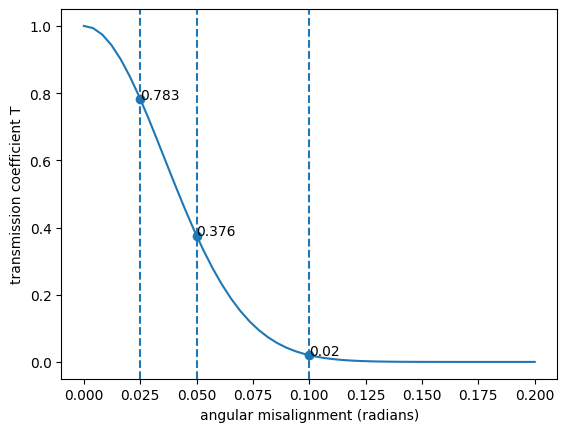

In [8]:
def T_ang(theta, n, omega, lam):
    return np.exp(-((np.pi*n*omega*theta)**2)/(lam**2))

theta = np.linspace(0,0.2)

T_angular = T_ang(theta,RI,MFD,wavelength)

fig,ax = plt.subplots()
ax.plot(theta,T_angular)
ax.set_xlabel('angular misalignment (radians)')
ax.set_ylabel('transmission coefficient T')
poi = np.array([0.025,0.05,0.1])
for i in range(len(poi)):
    plt.axvline(poi[i], linestyle='--')
T_poi = T_ang(poi,RI,MFD,wavelength)
T_labels = np.around(T_poi,3)
ax.scatter(poi,T_poi)
for i, txt in enumerate(T_labels):
    ax.annotate(txt, (poi[i], T_poi[i]))
plt.show()


# Trap Characterization
---------------
### Transmission as a function of air gap size
fit the data to the curve but add a y offset just to check it's behaving as expected

C:\Users\marku\AppData\Local\Temp\ipykernel_27640\934724415.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


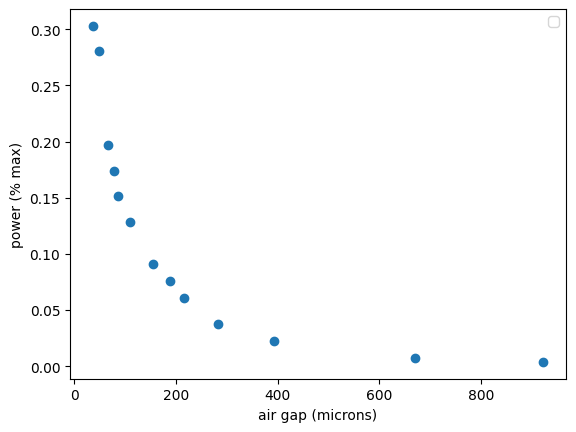

In [86]:
from scipy.optimize import curve_fit

def T_ag_yoffset(S,lam,n,omega,ox,oy,Ax,Ay): 
    """ 
    data given in units microns, nm, unitless, unitless and microwatts
    """
    S = S*10**(-6)
    lam = lam*10**(-9)
    
    Z = (lam*(Ax*(S+ox)))/(2*np.pi*n*(omega**2))
    return Ay*((1/(Z**2 + 1)) + oy)#*10**(-6)

airgaps = np.array([36.2, 49.6, 65.8, 78.2, 86.0, 110.4, 154.2, 189.4, 216.1, 282.5, 392.5, 671.2, 923.2])
powers = np.array([4, 3.7, 2.6, 2.3, 2.0, 1.7, 1.2, 1.0, 0.8, 0.5, 0.3, 0.1, 0.05])/13.2
#airgaps_cont = np.linspace(airgaps[0], airgaps[-1], 300)
airgaps_cont = np.linspace(-5000,5000,1000)

popt, pcov = curve_fit(T_ag_yoffset, airgaps, powers, bounds=([1050, 0.9, 6.2, -10000, -1000, -1000,-1000],[1080, 1.1, 7.2, 1000, 1000, 1000, 1000,]))

#plt.plot(airgaps_cont, T_ag_yoffset(airgaps_cont, *popt), 'g--',
         #label='fit: wavelength=%5.3f, refractive index=%5.3f, MFD=%5.3f, offset_x=%5.3f, offset_y=%5.3f, multiplier_x=%5.3f, multipler_y=%5.3f' % tuple(popt))
plt.scatter(airgaps,powers)
plt.xlabel('air gap (microns)')
plt.ylabel('power (% max)')
plt.legend()
plt.show()